# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
# logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    monkey_defs = params.monkey_defs
    mouse_defs = params.mouse_defs

    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    
    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"

finally:
    os.chdir(nbPath)

print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions

In [ ]:
5/2-1

1.5

In [53]:
def plot_moneky_fr_raster(ax):
    "`ax` should be oneaxes that covers the entire area of this plot"
    ax = utility.phantom_axes(ax)
    fig = ax.figure
    raster_example = ('Chewie_CO_FF_2016-10-13.p', 'Mihili_CO_VR_2014-03-03.p')
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)

    bbox = ax.get_position()
    x0, y0, x1, y1 = bbox.x0, bbox.y0, bbox.x1, bbox.y1


    # gs1   =fig.add_gridspec(nrows=1, ncols=8, left=0.1, bottom=0.4, right=.48, top=.8)
    # gs2   =fig.add_gridspec(nrows=1, ncols=8, left=.52, bottom=0.4, right=.9, top=.8)
    gs1   =fig.add_gridspec(nrows=1, ncols=8, left=x0, bottom=y0+.2, right=x0+bbox.width/2-.08, top=y1)
    gs2   =fig.add_gridspec(nrows=1, ncols=8, left=x0+bbox.width/2-.02, bottom=y0+.2, right=x1-.1, top=y1)
    # gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.945, bottom=0.5, right=.96, top=.7)
    gs_c = fig.add_gridspec(nrows=1, ncols=1, left=x1-.05, bottom=y0+.25, right=x1-.04, top=y1-.15)

    gs = [gs1,gs2]
    cax = fig.add_subplot(gs_c[:])

    trial=12
    for i,df in enumerate(raster_example_df):
        axes = []
        data = []
        for tar in range(8):
            df_ = pyal.select_trials(df, df.target_id==tar)
            data.append(df_.M1_rates[trial])
        data = np.array(data)
        vmin = np.amin(data, axis= (0,1))
        vmax = np.amax(data, axis= (0,1))

        for j,tarData in enumerate(data):
            ax = fig.add_subplot(gs[i][j])
            axes.append(ax)
            tarData -= vmin
            tarData /= (vmax - vmin)
            ax.imshow(tarData.T, aspect='auto')
            ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
    fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
    cax.set_title('Normalised\nfiring rate')
    ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
    ax.set_title('Monkey1')
    ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
    ax.set_title('Monkey2')

#======================== velocity
    # gs1   =fig.add_gridspec(nrows=1, ncols=8, left=0.1, bottom=0.32, right=.48, top=.39)
    # gs2   =fig.add_gridspec(nrows=1, ncols=8, left=.52, bottom=0.32, right=.9, top=.39)
    gs1   =fig.add_gridspec(nrows=1, ncols=8, left=x0, bottom=y0, right=x0+bbox.width/2-.08, top=y0+.15)
    gs2   =fig.add_gridspec(nrows=1, ncols=8, left=x0+bbox.width/2-.02, bottom=y0, right=x1-.1, top=y0+.15)

    gs = [gs1,gs2]

    axes = []
    for i,df in enumerate(raster_example_df):
        for tar in range(8):
            df_ = pyal.select_trials(df, df.target_id==tar)
            data = df_.vel[trial]
            ax = fig.add_subplot(gs[i][tar])
            axes.append(ax)
            ax.plot(data[:,0], label='$X$')
            ax.plot(data[:,1], label='$Y$')
            ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

    axes[0].set_ylabel('Velocity')
    axes[-1].legend(frameon=False, loc=(1.5,0.04))
    axes[0].set_xlabel('Time rel. to movement onset',loc='left')

/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


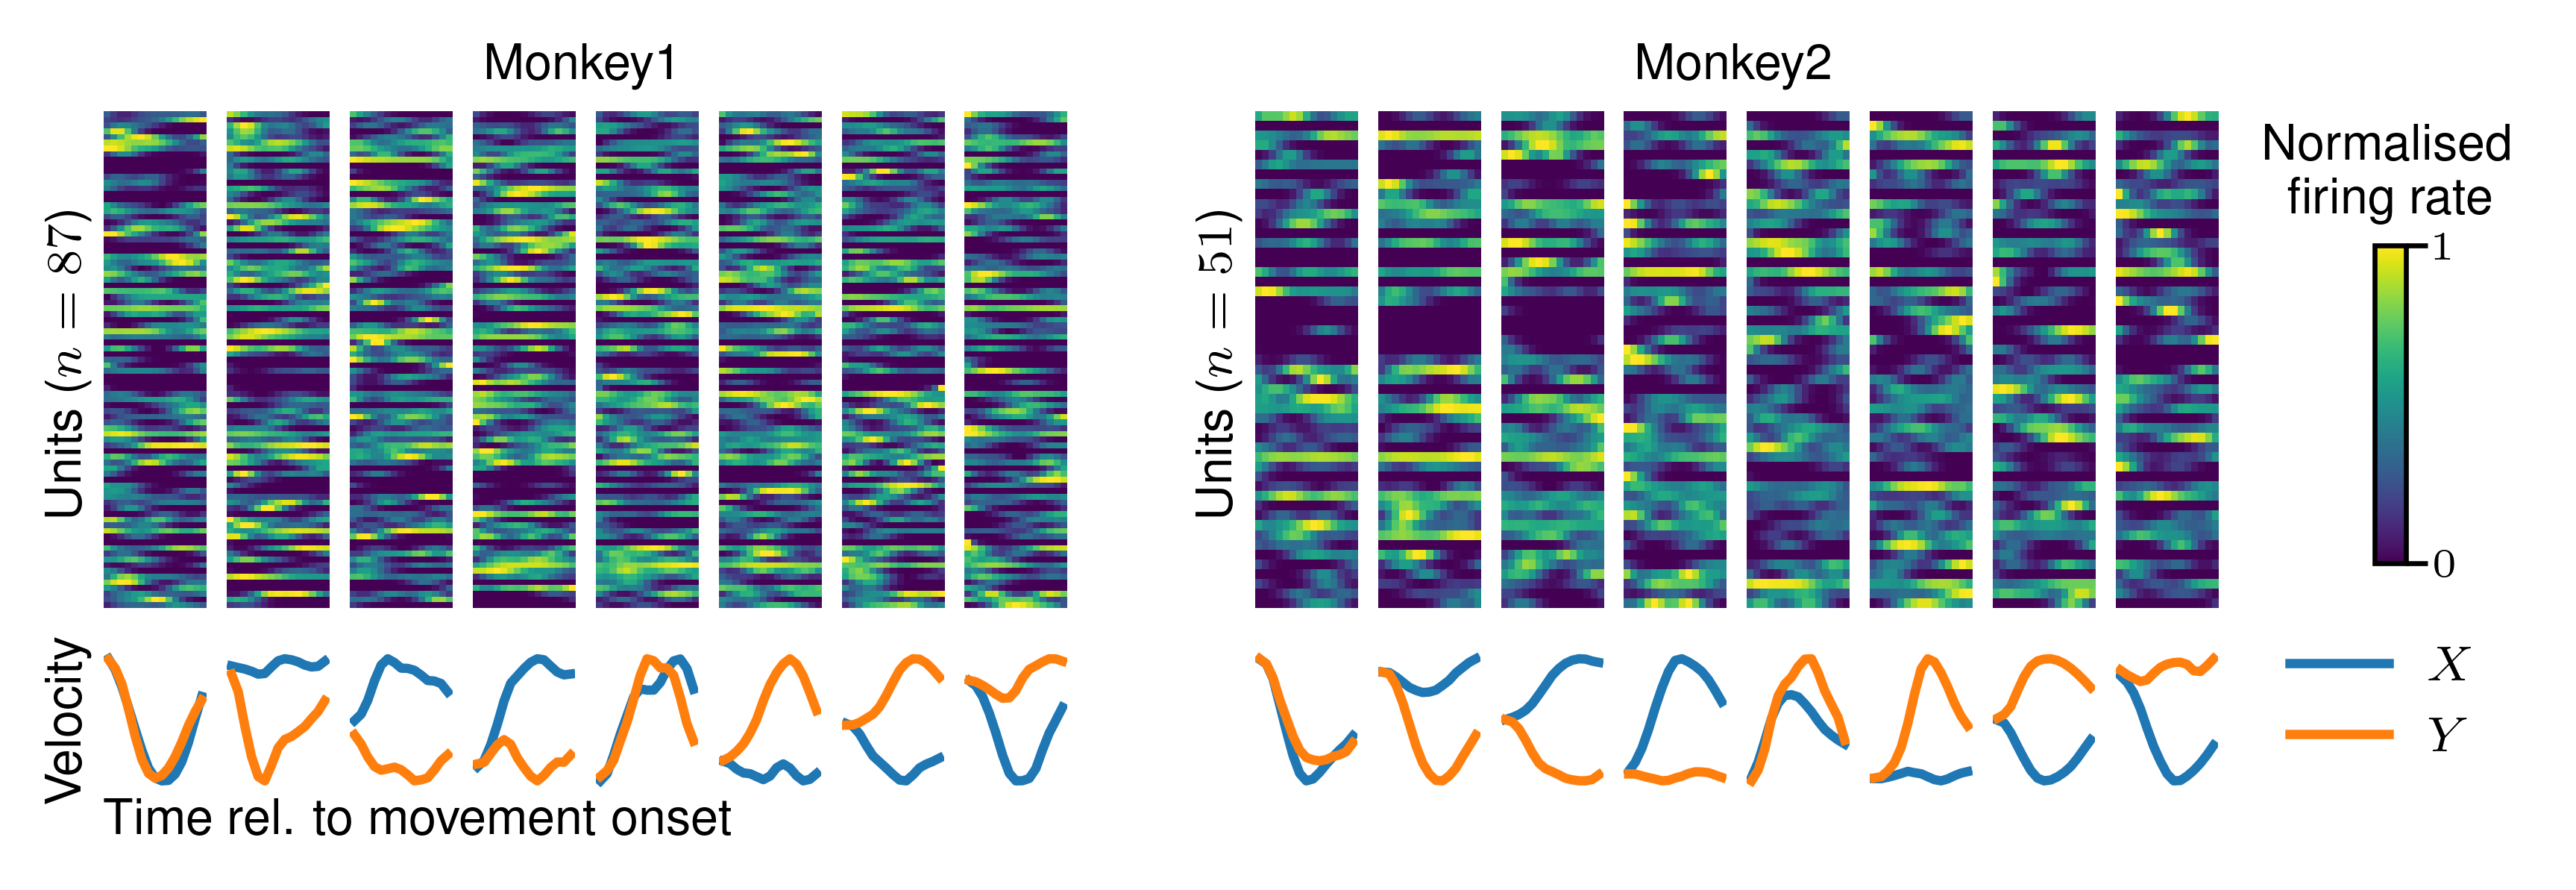

In [54]:
if "__file__" not in dir():
    plt.close('all')
    fig=plt.figure(figsize=(7,2))
    ax=fig.add_subplot(111)

    plot_moneky_fr_raster(ax)
    
    
    plt.show()

# Part 2
Plot figure

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    set_rc_params({'axes.labelsize':'x-small'})
    figsize=(7,7)
    fig=plt.figure(figsize=figsize,dpi=600)
    
   

    ##########################################
    # 1: task rules
    gs1   =fig.add_gridspec(nrows=1, ncols=1, left=0, bottom=0.6, right=.2, top=.74)
    ax1   =fig.add_subplot(gs1[0])
    gs1_   =fig.add_gridspec(nrows=1, ncols=1, left=.25, bottom=0.64, right=.39, top=.74)
    ax1_   =fig.add_subplot(gs1_[0])
    gs1__   =fig.add_gridspec(nrows=1, ncols=2, left=.43, bottom=0.64, right=.64, top=.74, wspace=.1)
    ax1__l  =fig.add_subplot(gs1__[0])
    ax1__r  =fig.add_subplot(gs1__[1])
    gs1___l   =fig.add_gridspec(nrows=1, ncols=1, left=.675, bottom=0.64, right=.815, top=.74)
    ax1___l  =fig.add_subplot(gs1___l[0])
    gs1___r   =fig.add_gridspec(nrows=1, ncols=1, left=.86, bottom=0.64, right=1, top=.74)
    ax1___r  =fig.add_subplot(gs1___r[0])

    
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    
    plot_panel_A(ax1_,ax1__l,ax1__r,ax1___l,ax1___r)

    

    ##########################################
    # 2: DLS
    gs2= fig.add_gridspec(nrows=1, ncols=4, left=0, bottom=0.44, right=.6, top=.54)
    
    axes2=plot_pre_post_traj(root, gs2, animalList2Ctrl, profile2pre, profile2post, sessionIndex1pre, sessionIndex2post)
    
    axes2[0].clear()
    plot_animal_image(axes2[0], animalList2Ctrl)
    axes2[0].set_ylabel('DLS')
    axes2[1].set_title('session #$-1$',fontsize='xx-small')
    axes2[2].set_title('Acute (#$+1$)',fontsize='xx-small')
    axes2[3].set_title(f'First stable (#$+{sessionIndex2post[-1]+1}$)',fontsize='xx-small')
    
    #adding the Before and After text and line
    y_top=gs2.top+.03
    add_underlined_text_centered_at(fig,p1=(axes2[1].get_position().bounds[0],y_top),p2=(gs2.right/4+axes2[1].get_position().bounds[2],y_top), s='Before')
    add_underlined_text_centered_at(fig,p1=(axes2[2].get_position().bounds[0],y_top),p2=(gs2.right,y_top), s='After')
    
    
    
    ##########################################
    # 3: DMS
    gs3= fig.add_gridspec(nrows=1, ncols=4, left=0, bottom=0.32, right=.6, top=.42)
    
    axes3=plot_pre_post_traj(root, gs3, animalList3Ctrl, profile3pre, profile3post, sessionIndex1pre, sessionIndex3post)
    
    axes3[0].clear()
    plot_animal_image(axes3[0], animalList3Ctrl)
    axes3[0].set_ylabel('DMS')
    axes3[3].set_title(f'(#$+{sessionIndex3post[-1]+1}$)',fontsize='xx-small')
    


    
    
    ##########################################
    # 4: DS
    gs4= fig.add_gridspec(nrows=1, ncols=4, left=0, bottom=0.2, right=.6, top=.3)
    
    axes4=plot_pre_post_traj(root, gs4, animalList4Ctrl, profile4pre, profile4post, sessionIndex1pre, sessionIndex4post, showText=True)
    
    axes4[0].clear()
    plot_animal_image(axes4[0], animalList4Ctrl)
    axes4[0].set_ylabel('DS')
    axes4[3].set_title(f'(#$+{sessionIndex4post[-1]+1}$)',fontsize='xx-small')

    #add text and line
    x_=np.mean([gs4.right,gs4.left])
    fig.add_artist(mpl.lines.Line2D([x_,x_] , [gs4.bottom,gs2.top],
                                    linestyle=':',lw=.7,color='gray', zorder=1))
   
    fig.add_artist(mpl.text.Text(x=x_, y=gs2.top,
                                        text=' Lesion', c='k',
                                        ha='center',va='bottom',fontsize='xx-small',rotation=90))


    
    ##########################################
    # 5: % entrance time time course
    gs5= fig.add_gridspec(nrows=1, ncols=1, left=0.67, bottom=.49, right=1, top=.59)
    ax5= fig.add_subplot(gs5[0])
    
    #DLS
    xDLS5=plot_event_rec(root, ax5, ProfilesDLS5,TaskParamToPlot=TaskParamToPlot5,
                         nPre=nPre5, nPost=nPost5, color=DLSColor,shift=ShiftDLS5)

    #DMS
    xDMS5=plot_event_rec(root, ax5, ProfilesDMS5,TaskParamToPlot=TaskParamToPlot5,
                         nPre=nPre5, nPost=nPost5, color=DMSColor,shift=ShiftDMS5)

    #DS
    xDS5 =plot_event_rec(root, ax5, ProfilesDS5,TaskParamToPlot=TaskParamToPlot5,
                         nPre=nPre5, nPost=nPost5, color=DSColor,shift=ShiftDS5)

    
    add_legend_for_lesion_types(ax5,(len(xDLS5),len(xDMS5),len(xDS5)))
    
    ax5.axhline(y=7, ls=':',c='gray',lw=1, zorder=-5)
    ax5.set_ylim([3,9])
    ax5.spines['left'].set_bounds(3,9)
    ax5.set_yticks(np.arange(3,10))
    ax5.set_yticklabels([3,'','','',7,'',9])
    ax5.set_ylabel('Entrance time (s)')
    ax5.set_xticklabels([])

    plot_session_def(ax5,sessionSlices=(preSlice6,postSlice6,finSlice6))


    
    
    
    ##########################################
    # 6: ET event plot
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=0.67, bottom=.2, right=.80, top=.32)
    ax6= fig.add_subplot(gs6[0])
        
    data6,*_=plot_event_1on1(root, ax6, Profiles6, colorCode=ColorCode, badAnimals=None, x_pos=(1,2,3,4),
                         TaskParamToPlot=TaskParamToPlot5, nInit=initSlice6, nPre=preSlice6, nPost=postSlice6,nFin=finSlice6)


    ax6.set_ylim([2,11])
    ax6.spines['left'].set_bounds(2,10)
    ax6.set_yticks(np.arange(2,11))
    ax6.set_yticklabels([2,'','','','',7,'','',10])
    ax6.set_ylabel('Entrance time (s)')


    #STATS
    p6,s6=bootstrapTest(data6[:,-1]-data6[:,1])
    permtest.plotSigPair(ax6,y=10,x=(2,4), s=s6, color=colorSig,lw=.8)
    
    
    p6_,s6_=bootstrapTest(data6[:,0]-data6[:,1])
    permtest.plotSigPair(ax6,y=10.9,x=(1,2), s=s6_, color=colorSig,lw=.8)

    p6__,s6__=bootstrapTest(data6[:,1]-data6[:,2])
    permtest.plotSigPair(ax6,y=10.9,x=(2,3), s=s6__, color=colorSig,lw=.8)
    
    p6___,s6___=bootstrapTest(data6[:,2]-data6[:,3])
    permtest.plotSigPair(ax6,y=10.9,x=(3,4), s=s6___, color=colorSig,lw=.8)

    
    
    ##########################################
    # 7: % %Routine time course
    gs7= fig.add_gridspec(nrows=1, ncols=1, left=0.67, bottom=.37, right=1, top=.47)
    ax7= fig.add_subplot(gs7[0])
    
    #DLS
    xDLS7=plot_event_rec(root, ax7, ProfilesDLS5,TaskParamToPlot=TaskParamToPlot7,
                         nPre=nPre5, nPost=nPost5, color=DLSColor,shift=ShiftDLS5)

    #DMS
    xDMS7=plot_event_rec(root, ax7, ProfilesDMS5,TaskParamToPlot=TaskParamToPlot7,
                         nPre=nPre5, nPost=nPost5, color=DMSColor,shift=ShiftDMS5)

    #DS
    xDS7 =plot_event_rec(root, ax7, ProfilesDS5,TaskParamToPlot=TaskParamToPlot7,
                         nPre=nPre5, nPost=nPost5, color=DSColor,shift=ShiftDS5)

    
    plot_session_def(ax7,sessionSlices=(preSlice6,postSlice6))
    plot_session_def(ax7,sessionSlices=(finSlice6,))
    
    ax7.set_ylim([0,1])
    ax7.spines['left'].set_bounds(0,1)
    ax7.set_yticks(np.arange(0,1.1,.2))
    ax7.set_yticklabels([0]+['']*4+[100])
    ax7.set_ylabel('% Routine',labelpad=-3)
    ax7.set_xlabel('Session # relative to lesion', labelpad=0)
    
    
    x_=fig.transFigure.inverted().transform(ax7.transData.transform((0,0)))[0]
    fig.add_artist(mpl.lines.Line2D([x_,x_] , [ax7.get_position().bounds[1], ax5.get_position().get_points()[1][1]],
                                    linestyle=':',lw=.7,color='gray', zorder=1))

    
    ##########################################
    # 8: %Routine event plot
    gs8= fig.add_gridspec(nrows=1, ncols=1, left=0.87, bottom=.2, right=1, top=.32)
    ax8= fig.add_subplot(gs8[0])
    
    data8,*_=plot_event_1on1(root, ax8, Profiles6, colorCode=ColorCode, badAnimals=None, x_pos=(1,2,3,4),
                         TaskParamToPlot=TaskParamToPlot7, nInit=initSlice6, nPre=preSlice6, nPost=postSlice6,nFin=finSlice6)



    ax8.set_ylim([0,1.1])
    ax8.spines['left'].set_bounds(0,1)
    ax8.set_yticks(np.arange(0,1.1,.2))
    ax8.set_yticklabels([0]+['']*4+[100])
    ax8.set_ylabel('% Routine',labelpad=-2)
    
    
    #STATS
    p8,s8=bootstrapTest(data8[:,-1]-data8[:,1])
    permtest.plotSigPair(ax8,y=1,x=(2,4), s=s8, color=colorSig,lw=.8)

    p8_,s8_=bootstrapTest(data8[:,0]-data8[:,1])
    permtest.plotSigPair(ax8,y=1.09,x=(1,2), s=s8_, color=colorSig,lw=.8)

    p8__,s8__=bootstrapTest(data8[:,1]-data8[:,2])
    permtest.plotSigPair(ax8,y=1.09,x=(2,3), s=s8__, color=colorSig,lw=.8)
    
    p8___,s8___=bootstrapTest(data8[:,2]-data8[:,3])
    permtest.plotSigPair(ax8,y=1.09,x=(3,4), s=s8___, color=colorSig,lw=.8)


    
    

    
#     fig.align_ylabels([ax5,ax6,ax7])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax1,ax1_,ax1__l,ax1___r,axes2[0],axes3[0],axes4[0],ax5,ax7,ax6,ax8)
    OFFX=np.array([.02]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
    
    OFFY[[-1,-2]]=0
    OFFX[[-1,-2]]=0.06
    OFFX[[-3,-4]]=0.06
    OFFX[[3,2,1]]=0.04
    
    add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','Task_Example_Group.pdf'),
                format='pdf', bbox_inches='tight')
    
    thisPath  =os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','Task_Example_Group.pdf')
    sketchPath=os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','TreadmillSketch.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=15, ty=245, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)
    
    plt.show()
    plt.close('all')
    matplotlib.rcdefaults()